In [2]:
from cpclasses import *

In [3]:
class PhysicsInformed(torch.nn.Module):

    def __init__(self, N_hidden_depth=2, N_hidden_width=16):
        super().__init__()
        assert N_hidden_depth > 0, 'Must have at least one hidden layer'

        self.layers = torch.nn.Sequential(
            torch.nn.Linear(1, N_hidden_width),
            torch.nn.SiLU(),
            
                *[torch.nn.Linear(N_hidden_width, N_hidden_width), torch.nn.SiLU()] * (N_hidden_depth-1),
            torch.nn.Linear(N_hidden_width, 1)
         )

    def forward(self, x):
        return self.layers(x)

    def prediction_and_derivative(self, x):
        prediction = self.forward(x)
        derivative = torch.autograd.grad(prediction, x, torch.ones_like(prediction), create_graph=True)[0]

        return prediction, derivative



In [4]:
ModelX = PhysicsInformed(N_hidden_depth=2, N_hidden_width=16)
ModelY = PhysicsInformed(N_hidden_depth=2, N_hidden_width=16)

In [9]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(list(ModelX.parameters()) + list(ModelY.parameters()), lr=0.001)

ss = torch.linspace(0, 21, 100, requires_grad=True).reshape(-1,1)

a = 36.78558520




def train(epochs =2500, smin=0, smax = 21, a = 36.78558520):
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        ss = torch.rand((32,1), requires_grad=True) * (smax - smin) + smin
        s0 = torch.zeros((1,1), requires_grad=True)
        s1 = torch.ones((1,1), requires_grad=True)
        _, dxds = ModelX.prediction_and_derivative(ss)
        _, dyds = ModelY.prediction_and_derivative(ss)

        loss = criterion(dxds, a/torch.sqrt(a**2 +ss**2))
        loss += criterion(dyds, ss/torch.sqrt(a**2 +ss**2))

        x0, slope_x0 = ModelX.prediction_and_derivative(s0)
        y0, slope_y0 = ModelY.prediction_and_derivative(s0)
        loss += criterion(x0, s0)
        loss += criterion(y0, s0)
        loss += criterion(slope_x0, s1)
        loss += criterion(slope_y0, s0)
        
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

In [ ]:
widths_and_depths = [(2,2), (4,2), (8,2)]
fig, axs = plt.subplots(1, 3, figsize=(15,5))


for ax, (w,d) in zip(axs, widths_and_depths):
    ModelX = PhysicsInformed(N_hidden_depth=d, N_hidden_width=w)
    ModelY = PhysicsInformed(N_hidden_depth=d, N_hidden_width=w)
    optimizer = torch.optim.Adam(list(ModelX.parameters()) + list(ModelY.parameters()), lr=0.001)
    train(epochs=2500)
    ss = torch.linspace(0, 21, 100, requires_grad=True).reshape(-1,1)
    x, _ = ModelX.prediction_and_derivative(ss)
    y, _ = ModelY.prediction_and_derivative(ss)
    ax.plot(x.detach().numpy(), y.detach().numpy(), label='y(x)')
    ax.set_title(f'Width: {w}, Depth: {d}')
    ax.legend()


Epoch 0, Loss: 3.0254621505737305
Epoch 100, Loss: 2.5148708820343018
Epoch 200, Loss: 2.276074171066284
Epoch 300, Loss: 2.1450681686401367
Epoch 400, Loss: 2.0716233253479004
Epoch 500, Loss: 2.0193135738372803
Epoch 600, Loss: 1.973257303237915
Epoch 700, Loss: 1.916552186012268
Epoch 800, Loss: 1.813079833984375
Epoch 900, Loss: 1.6326837539672852
Epoch 1000, Loss: 1.370633840560913
Epoch 1100, Loss: 1.064771294593811
Epoch 1200, Loss: 0.931555449962616
Epoch 1300, Loss: 0.9621660113334656
Epoch 1400, Loss: 0.9860771894454956
Epoch 1500, Loss: 0.9330431818962097
Epoch 1600, Loss: 0.9531570672988892
Epoch 1700, Loss: 0.9331241846084595
Epoch 1800, Loss: 0.9539467692375183
Epoch 1900, Loss: 0.9346110820770264
Epoch 2000, Loss: 0.9159119725227356
Epoch 2100, Loss: 0.9801483154296875
Epoch 2200, Loss: 0.930883526802063
Epoch 2300, Loss: 0.9530842900276184
Epoch 2400, Loss: 0.8879054188728333
Epoch 0, Loss: 2.0248501300811768
Epoch 100, Loss: 1.241860032081604
Epoch 200, Loss: 0.3350141

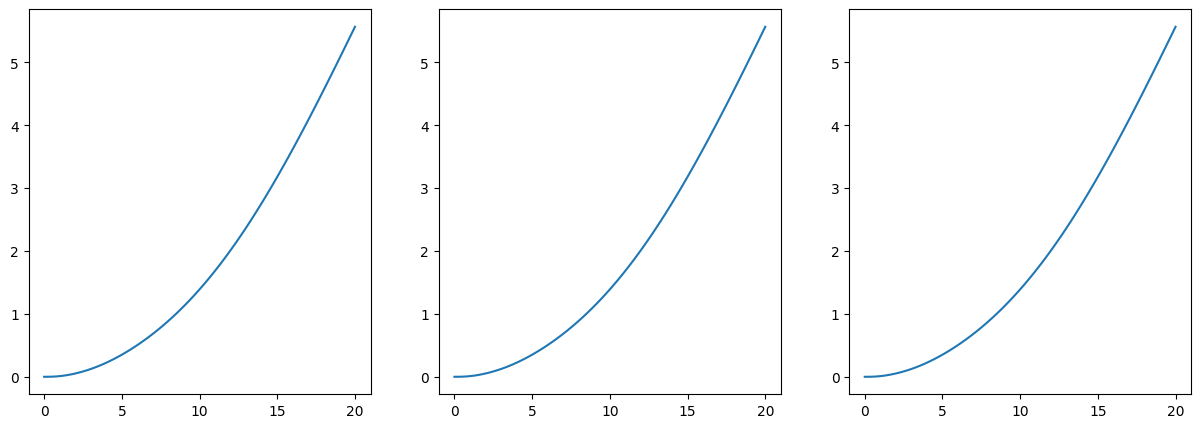

In [13]:
for ax in axs:
    ax.clear()
    ax.plot(x.detach().numpy(), y.detach().numpy(), label='x')
    
fig